In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from data_loader import load_xenium_breast_cancer
from prismo import PRISMO

tab10 = plt.get_cmap('tab10').colors
tab10 = [colors.rgb2hex(color) for color in tab10]

tab20 = plt.get_cmap('tab20').colors
tab20 = [colors.rgb2hex(color) for color in tab20]

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
data = load_xenium_breast_cancer()
data["group_xenium"]["rna"].var_names = (data["group_xenium"]["rna"].var["symbol"].astype(str))
adata = data["group_xenium"]["rna"]
adata = adata[adata.obs.celltype!="Unlabeled"]

model = PRISMO.load("/data/florin/prismo_project/prismo-analysis/application_xenium_florin/models/uninformed.h5")

The stored model was created with a different version of PRISMO. Some features may not work.


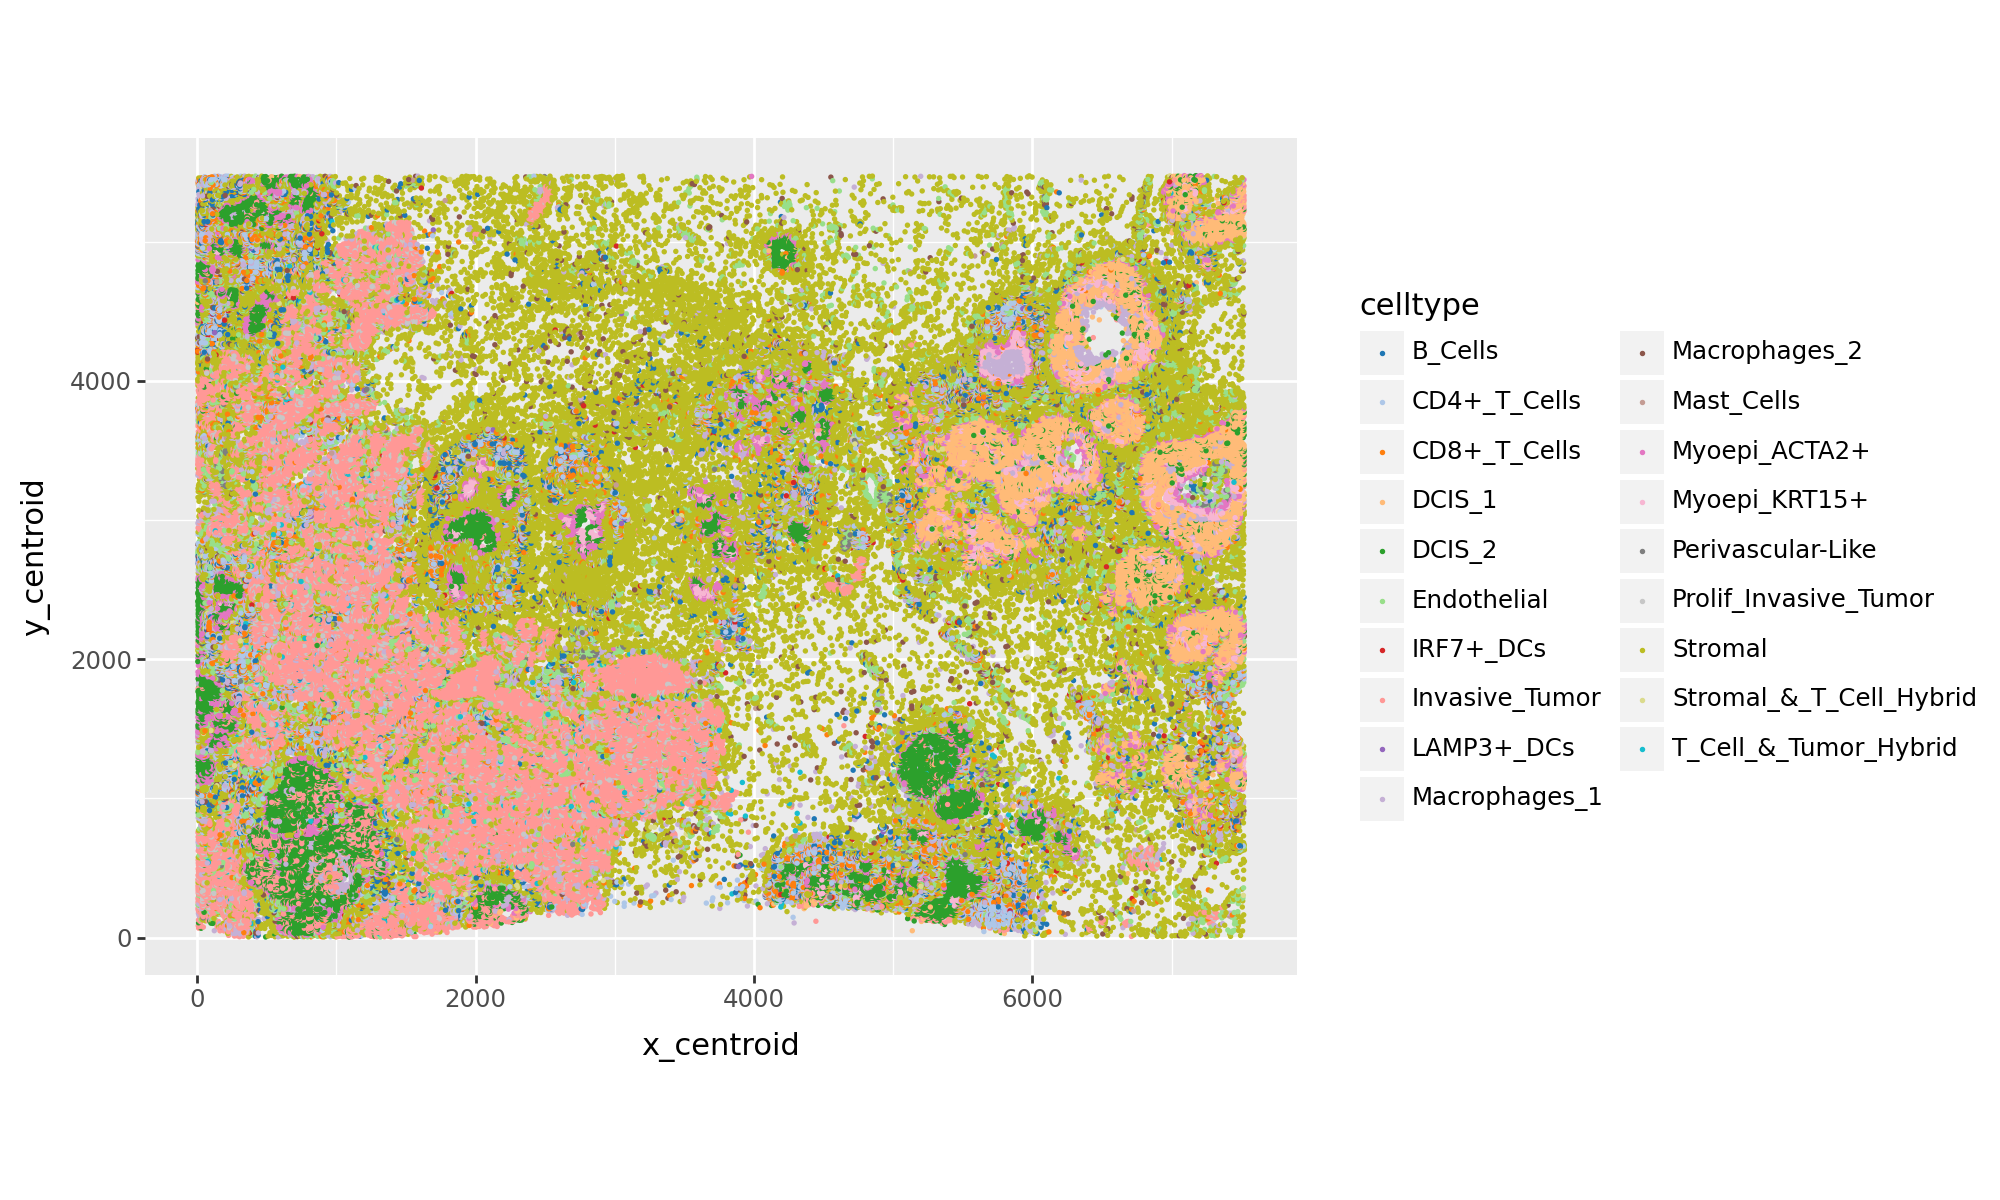

In [3]:
plot = (
    ggplot(adata.obs, aes(x="x_centroid", y="y_centroid", color="celltype"))
    + geom_point(size=0.1)
    + theme(figure_size=(10, 6))
    + coord_equal()
    + scale_color_manual(values=tab20)
)
plot.show()

## Compute neigbourhood composition for every cell

In [4]:
df = adata.obs[["celltype", "x_centroid", "y_centroid"]]
df.columns = ["celltype", "x", "y"]

n_neighbors = 25

coords = df[['x', 'y']].values
nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

def get_composition(indices, df):
    neighbor_indices = indices[1:]  # Exclude the first index as it is the point itself
    neighbor_celltypes = df.iloc[neighbor_indices]['celltype']
    return neighbor_celltypes.value_counts().to_dict()

df['composition'] = [get_composition(indices[i], df) for i in range(len(df))]

# Expand the composition column into multiple columns
composition_df = pd.json_normalize(df['composition']).fillna(0)
composition_df.index = df.index
df = pd.concat([df.drop(columns=['composition']), composition_df], axis=1)

# Select the composition columns
composition_columns = composition_df.columns
composition_data = df[composition_columns]

# Normalize the composition data
scaler = StandardScaler()
composition_data_normalized = scaler.fit_transform(composition_data)

/tmp/ipykernel_779828/398009425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Celltype specific analysis

In [5]:
celltype = "Macrophages_1"

celltype_inds = adata.obs["celltype"] == celltype
adata_celltype = adata[celltype_inds].copy()

### Neigbourhood clustering

In [6]:
composition_data_normalized_celltype = composition_data_normalized[celltype_inds]
composition_data_celltype = composition_data[celltype_inds]

kmeans = KMeans(n_clusters=5)
adata_celltype.obs["cluster"] = kmeans.fit_predict(composition_data_normalized_celltype).astype("str")


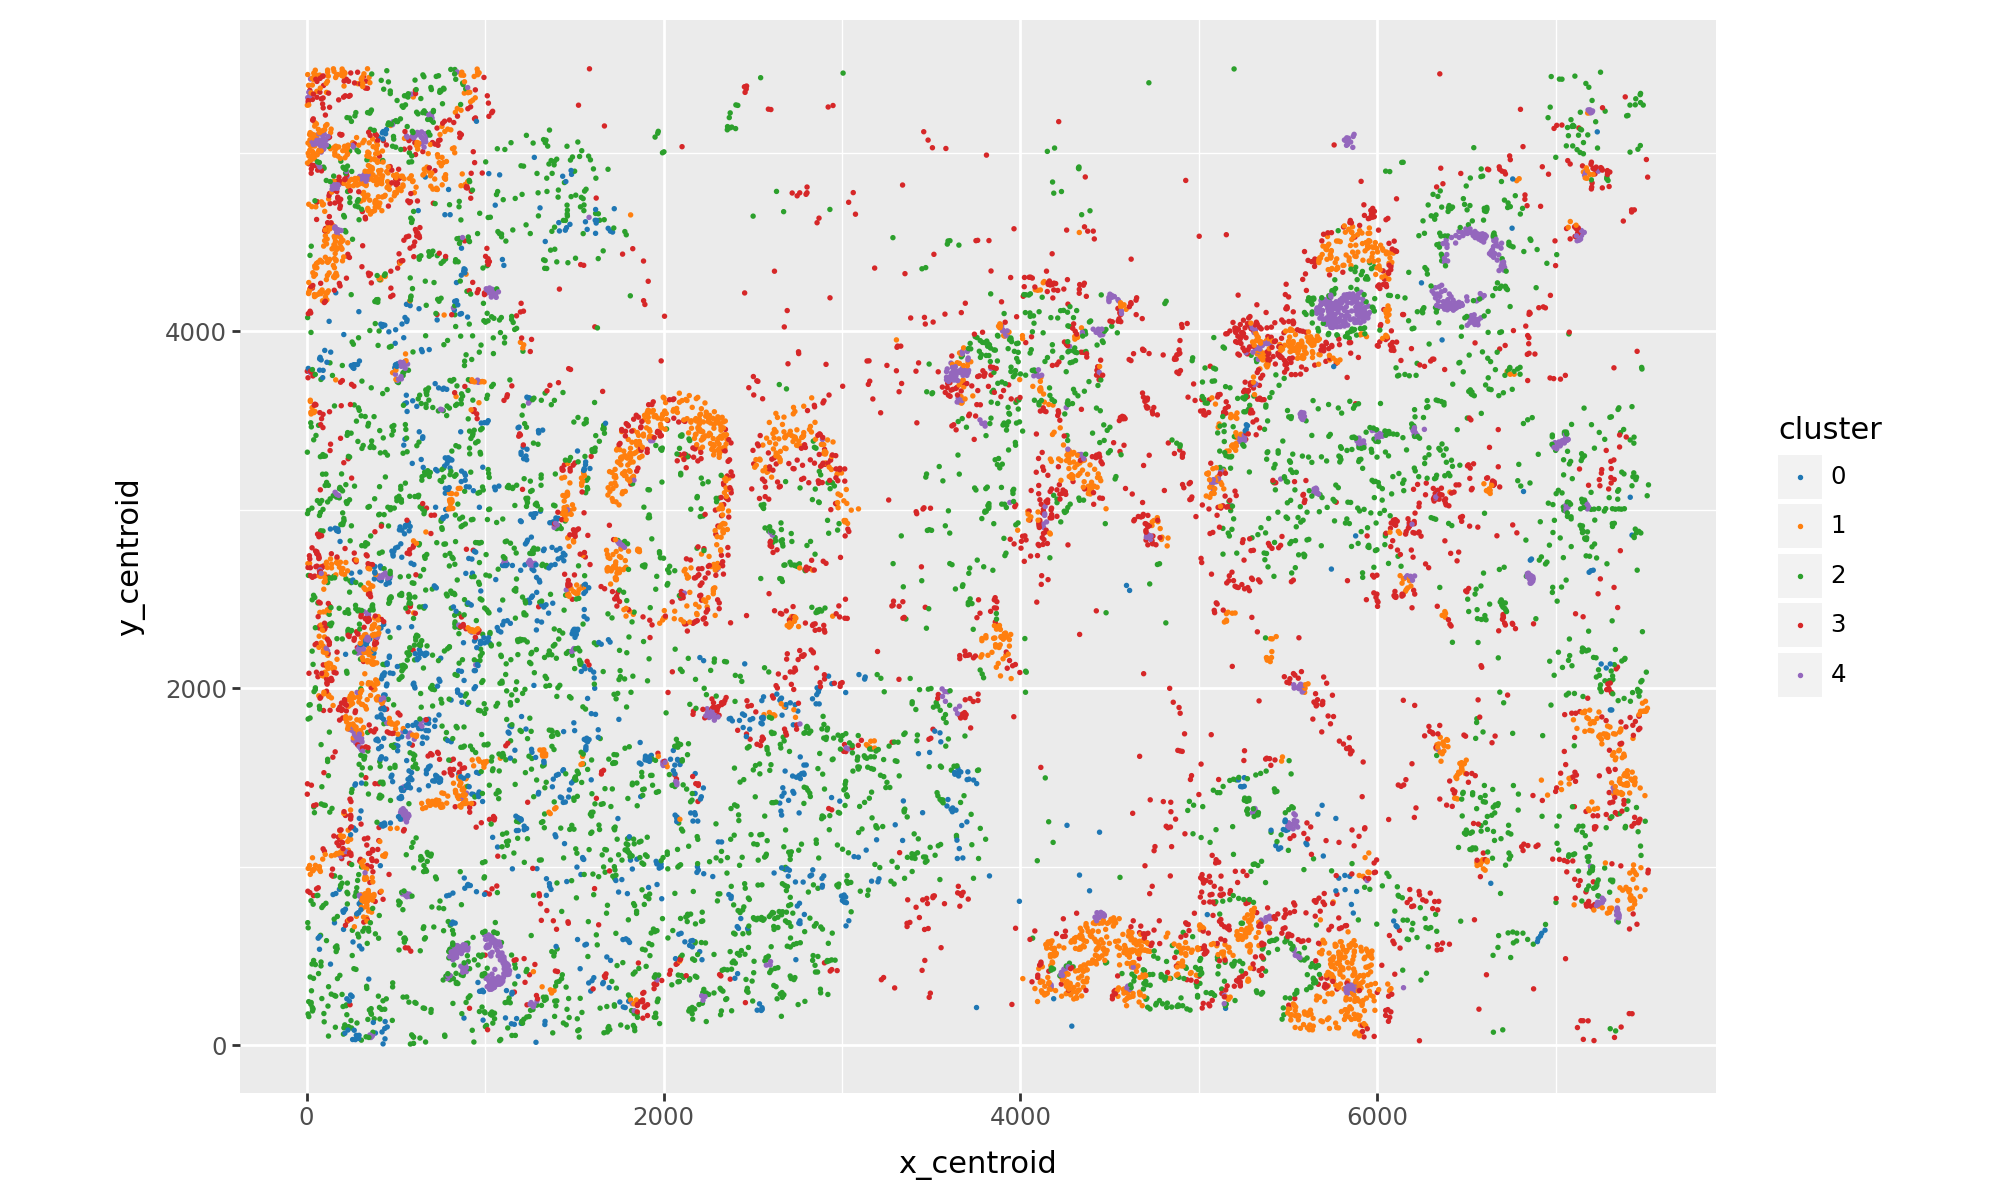

In [7]:
plot = (
    ggplot(adata_celltype.obs, aes(x="x_centroid", y="y_centroid", color="cluster"))
    + geom_point(size=0.1)
    + theme(figure_size=(10, 6))
    + coord_equal()
    + scale_color_manual(values=tab10)
)
plot.show()

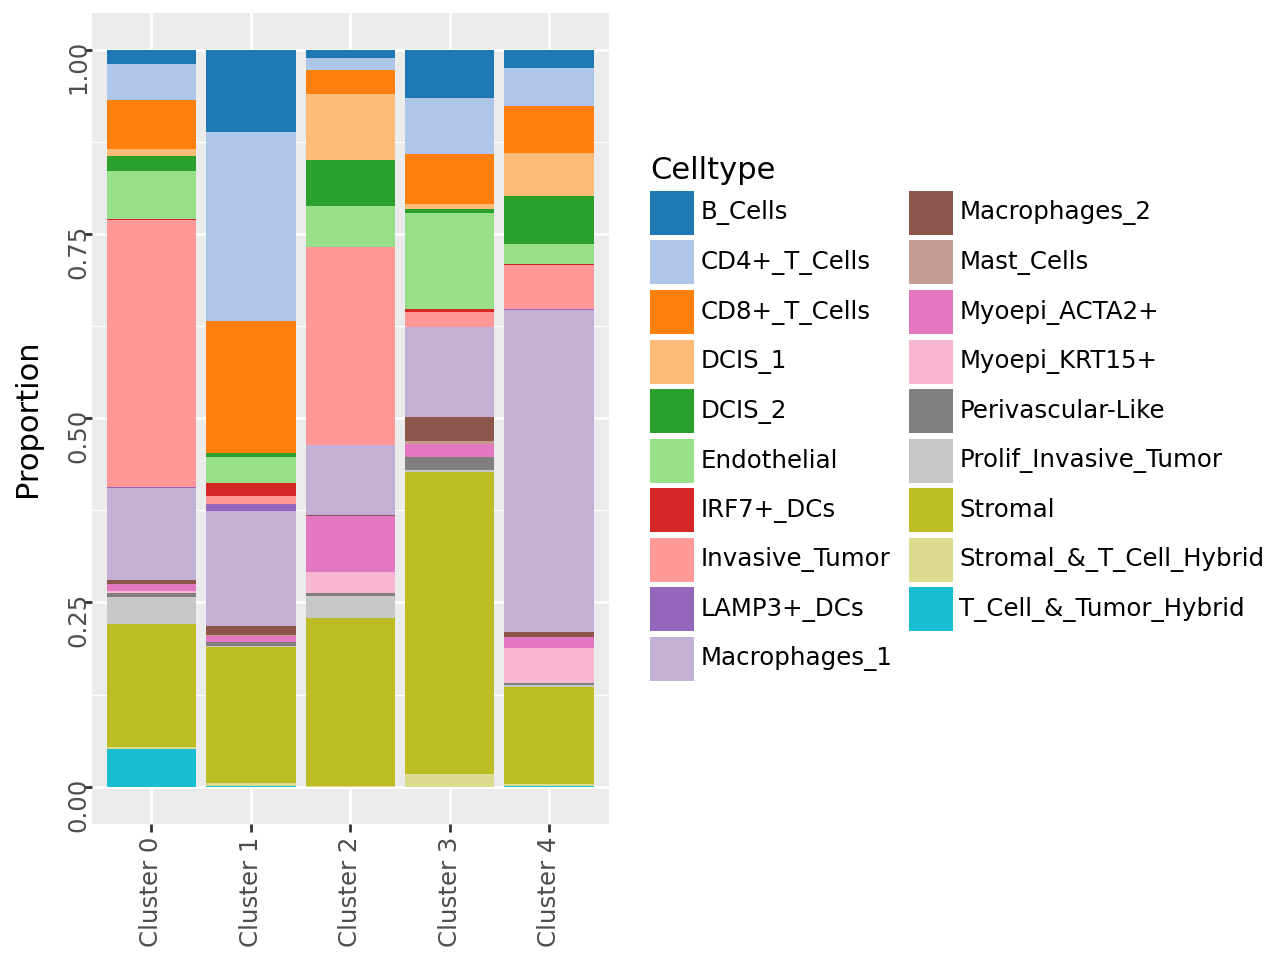

In [8]:
cluster_composition = []

for cluster in np.unique(adata_celltype.obs["cluster"]):
    inds = adata_celltype.obs["cluster"] == cluster
    cluster_composition.append(pd.DataFrame(composition_data_celltype[inds].sum(axis=0)))
    cluster_composition[-1].columns = [f"Cluster {cluster}"]
    
cluster_composition = pd.concat(cluster_composition, axis=1)
cluster_composition_normalized = cluster_composition.div(cluster_composition.sum(axis=0), axis=1)

cluster_composition_normalized_long = cluster_composition_normalized.reset_index(names="Celltype").melt(id_vars="Celltype", var_name="Cluster", value_name="Composition")

plot = (
    ggplot(cluster_composition_normalized_long, aes(x="Cluster", y="Composition", fill="Celltype"))
    + geom_bar(stat="identity", position="fill")
    + theme(axis_text=element_text(rotation=90, hjust="center"))
    + scale_fill_manual(values=tab20)
    + labs(x="", y="Proportion")
)
plot.show()

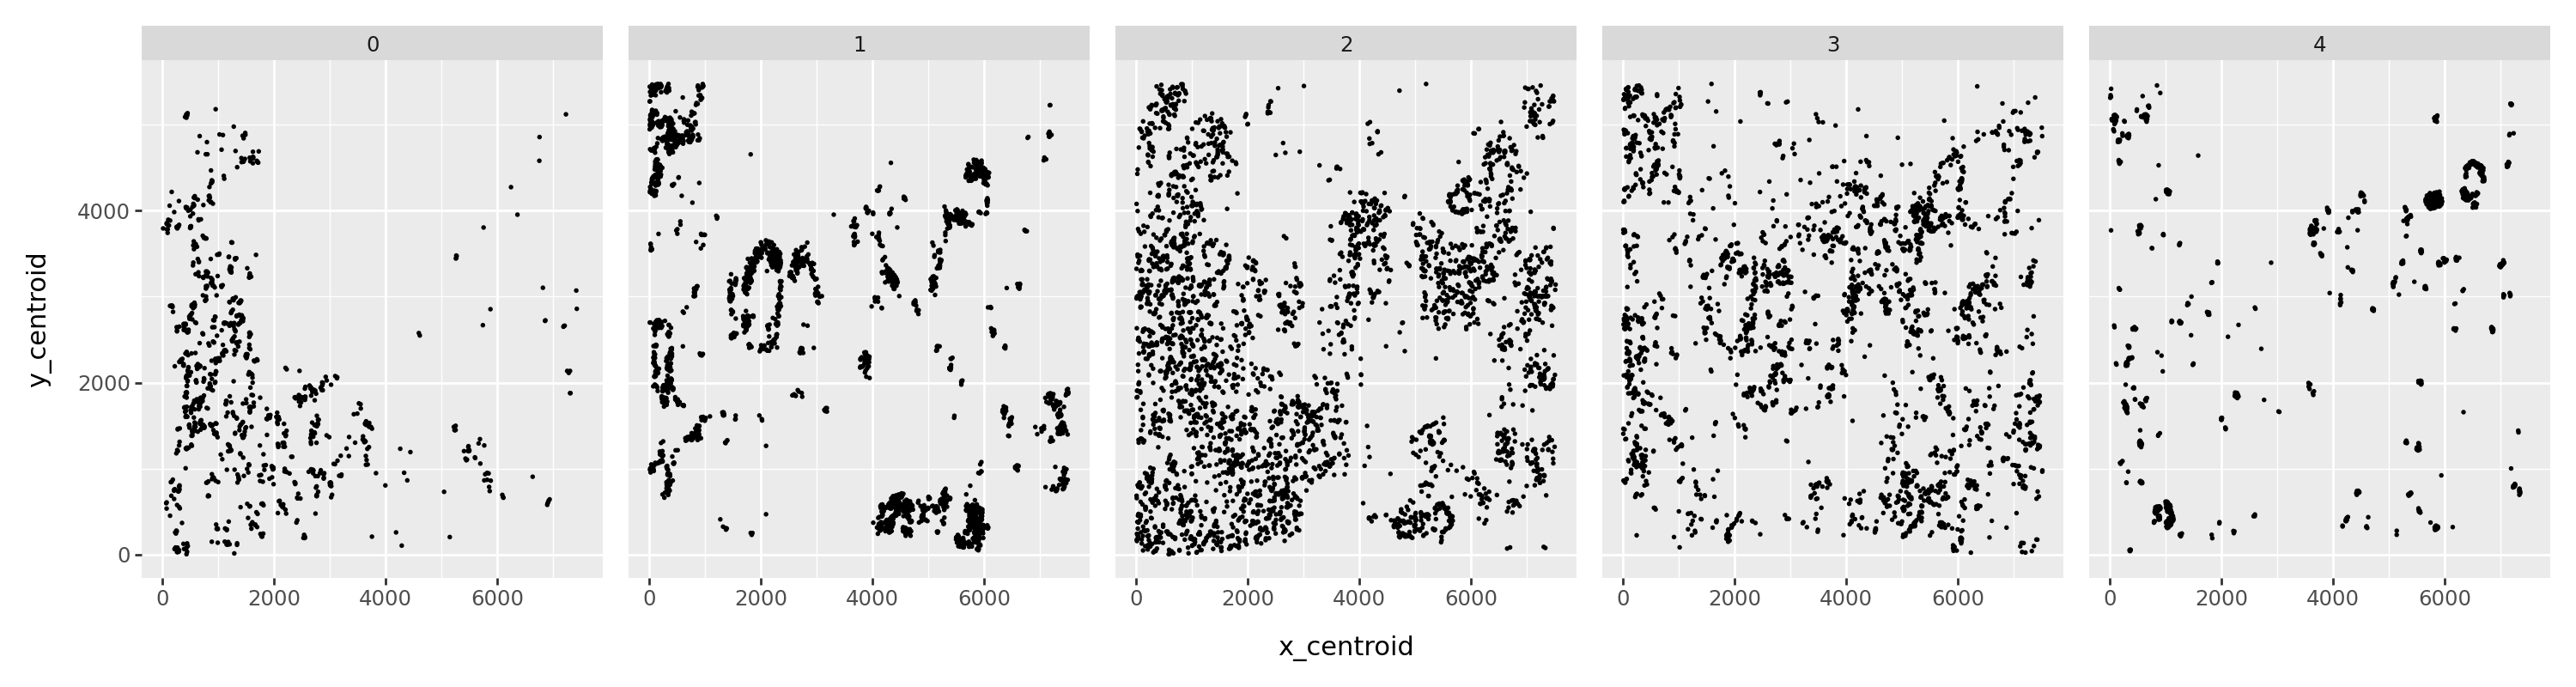

In [9]:
plot = (
    ggplot(adata_celltype.obs, aes(x="x_centroid", y="y_centroid"))
    + geom_point(size=0.1)
    + theme(figure_size=(15, 4))
    + facet_wrap("~cluster", scales="fixed", ncol=5)
)
plot.show()

### Logistic regression

In [10]:
factors_celltype = model.get_factors("pandas")["group_xenium"].loc[adata.obs_names][celltype_inds]
X_train, X_test, y_train, y_test = train_test_split(factors_celltype.values, adata_celltype.obs["cluster"].values, test_size=0.1)
logregr = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = logregr.predict(X_test)

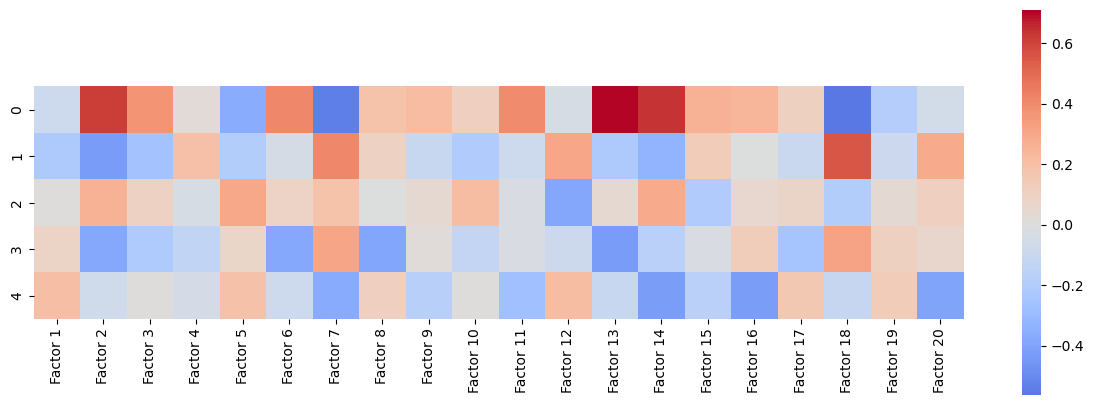

In [11]:
plt.figure(figsize=(15, 5))

sns.heatmap(
    logregr.coef_,
    square=True,
    cmap='coolwarm',
    center=0,
    xticklabels=factors_celltype.columns,
    yticklabels=np.unique(adata_celltype.obs["cluster"].unique()),
    )
plt.show()

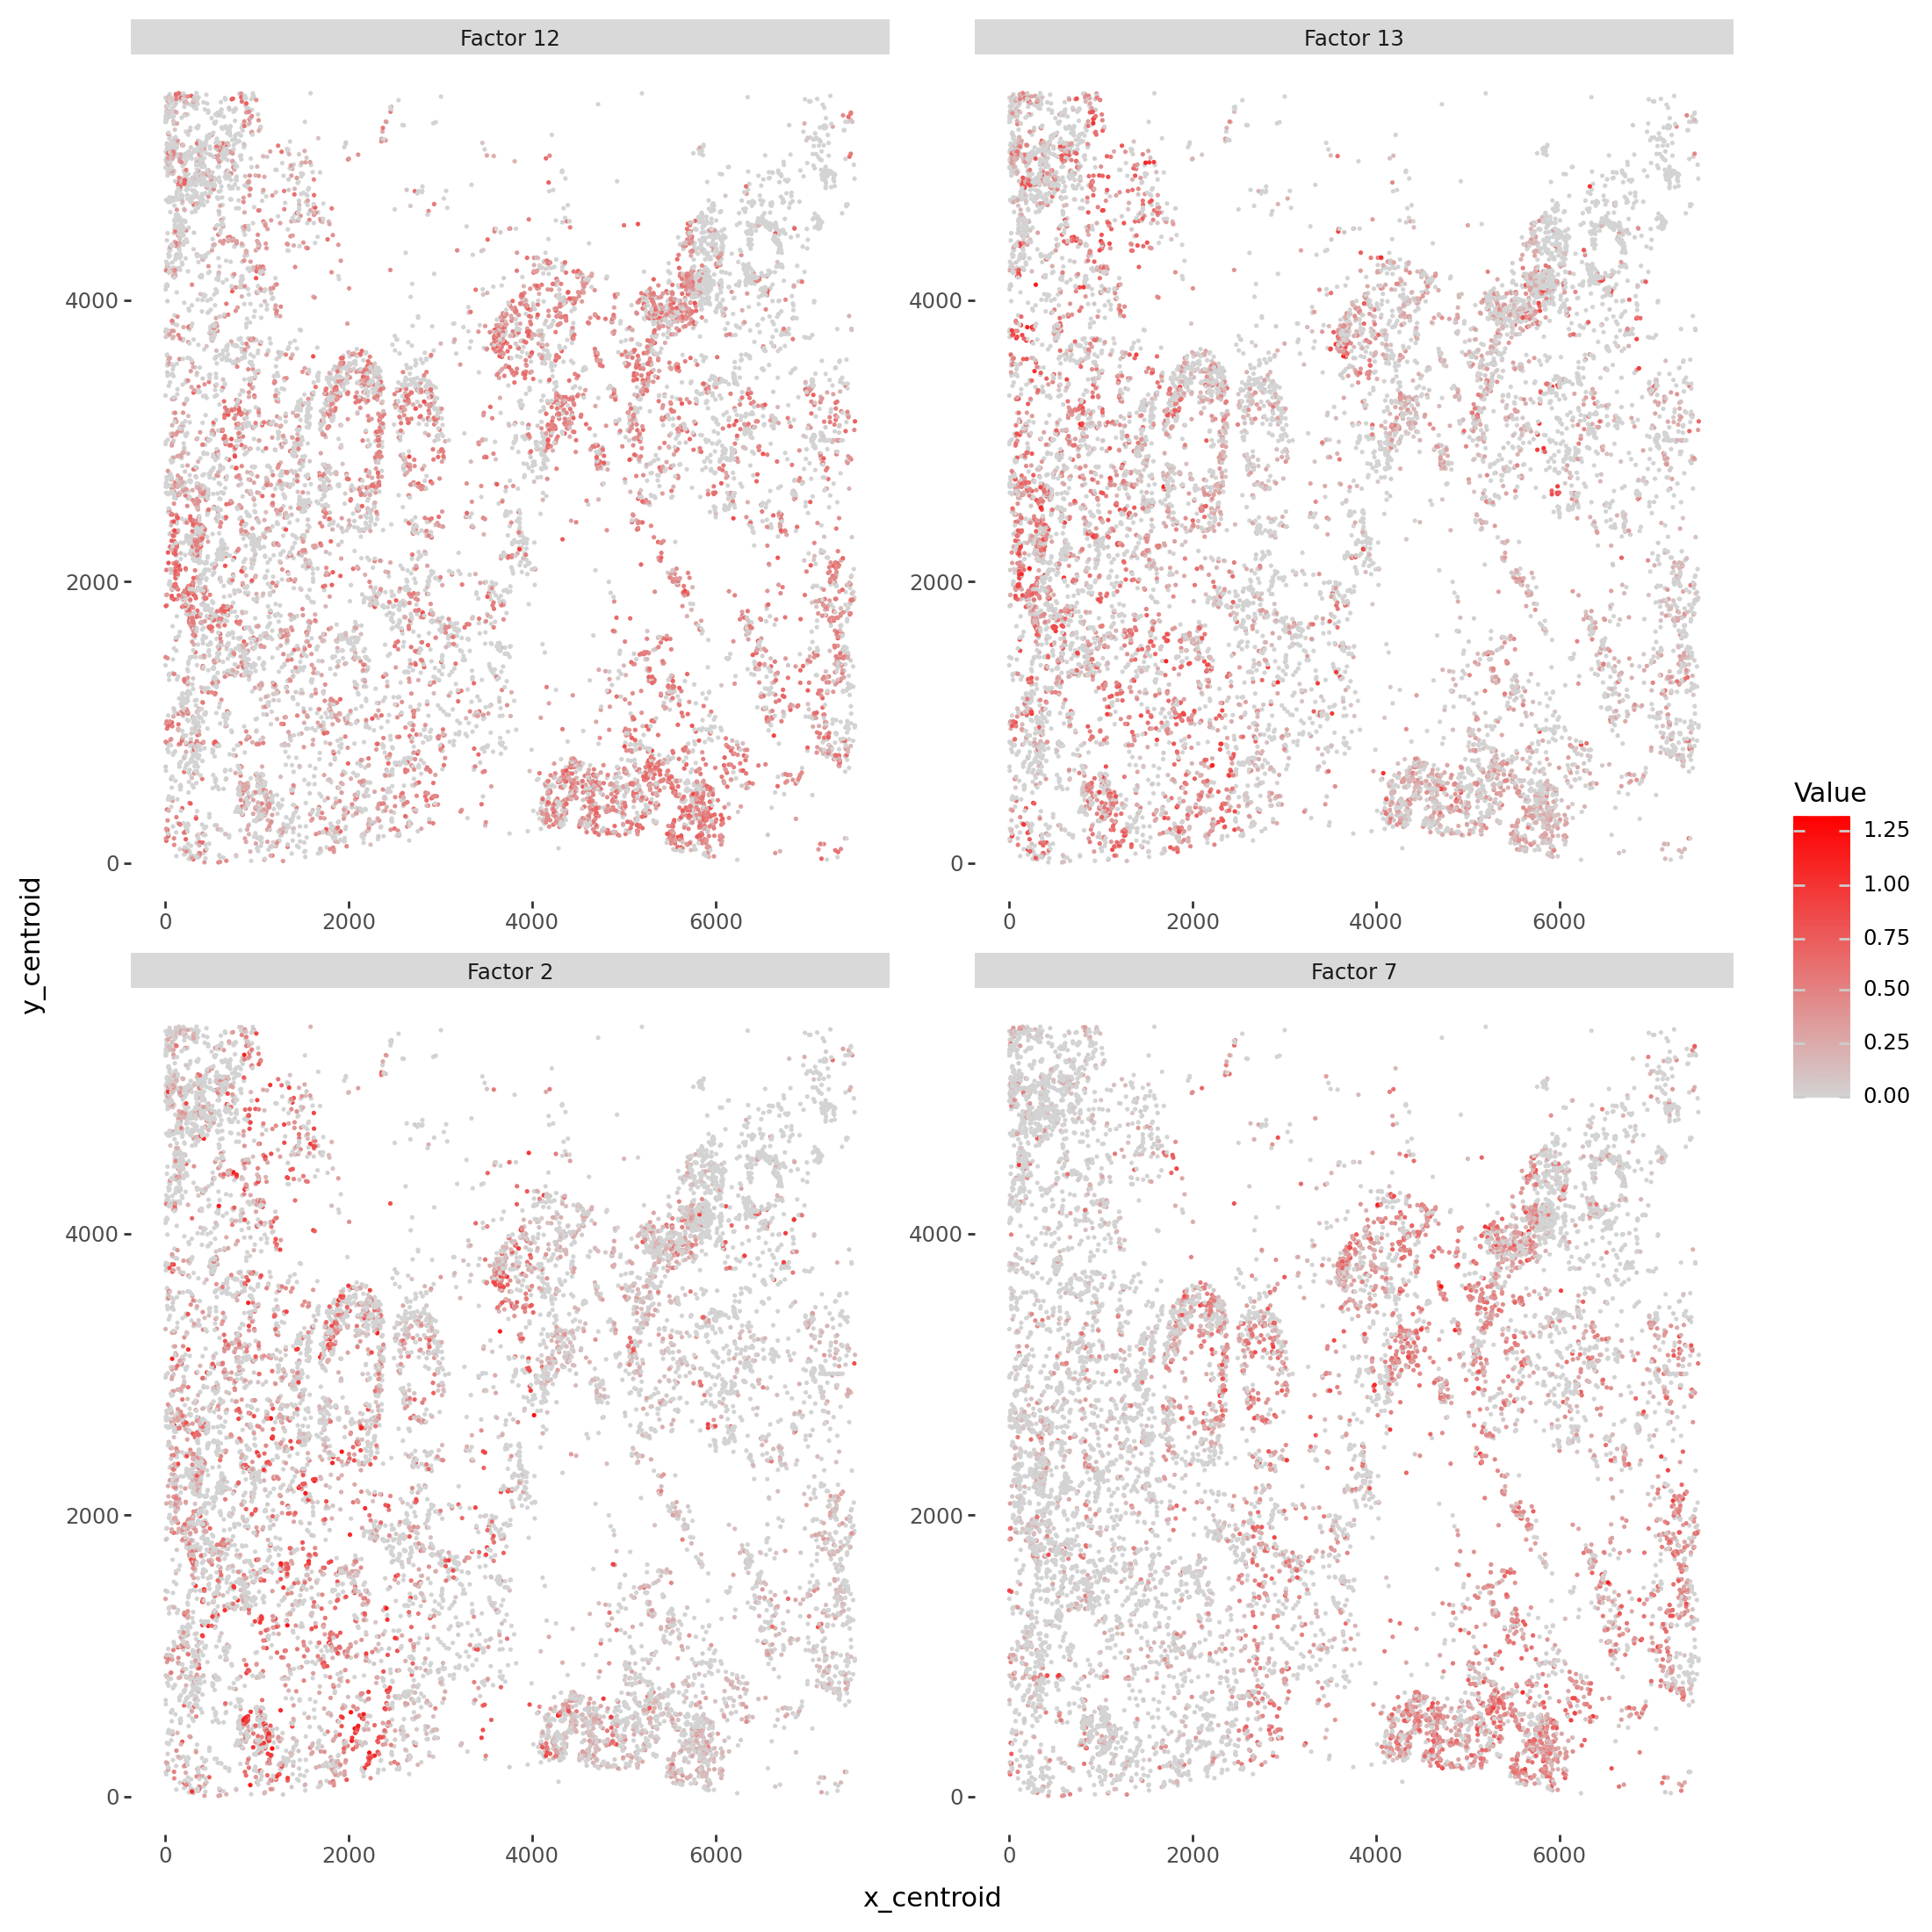

In [12]:
factors = [
    "Factor 2",
    "Factor 7",
    "Factor 12",
    "Factor 13",
    ]

df = factors_celltype[factors].copy()
df["x_centroid"] = adata_celltype.obs["x_centroid"].values
df["y_centroid"] = adata_celltype.obs["y_centroid"].values
df = df.melt(id_vars=["x_centroid", "y_centroid"], var_name="Factor", value_name="Value")

plot = (
    ggplot(df, aes(x="x_centroid", y="y_centroid", color="Value"))
    + geom_point(size=0.05)
    + facet_wrap("~Factor", scales="free", ncol=2)
    + scale_color_gradient(low="lightgrey", high="red")
    + theme(
        panel_background=element_blank(),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(), 
        figure_size=(11, 11),
        )
)
plot.show()

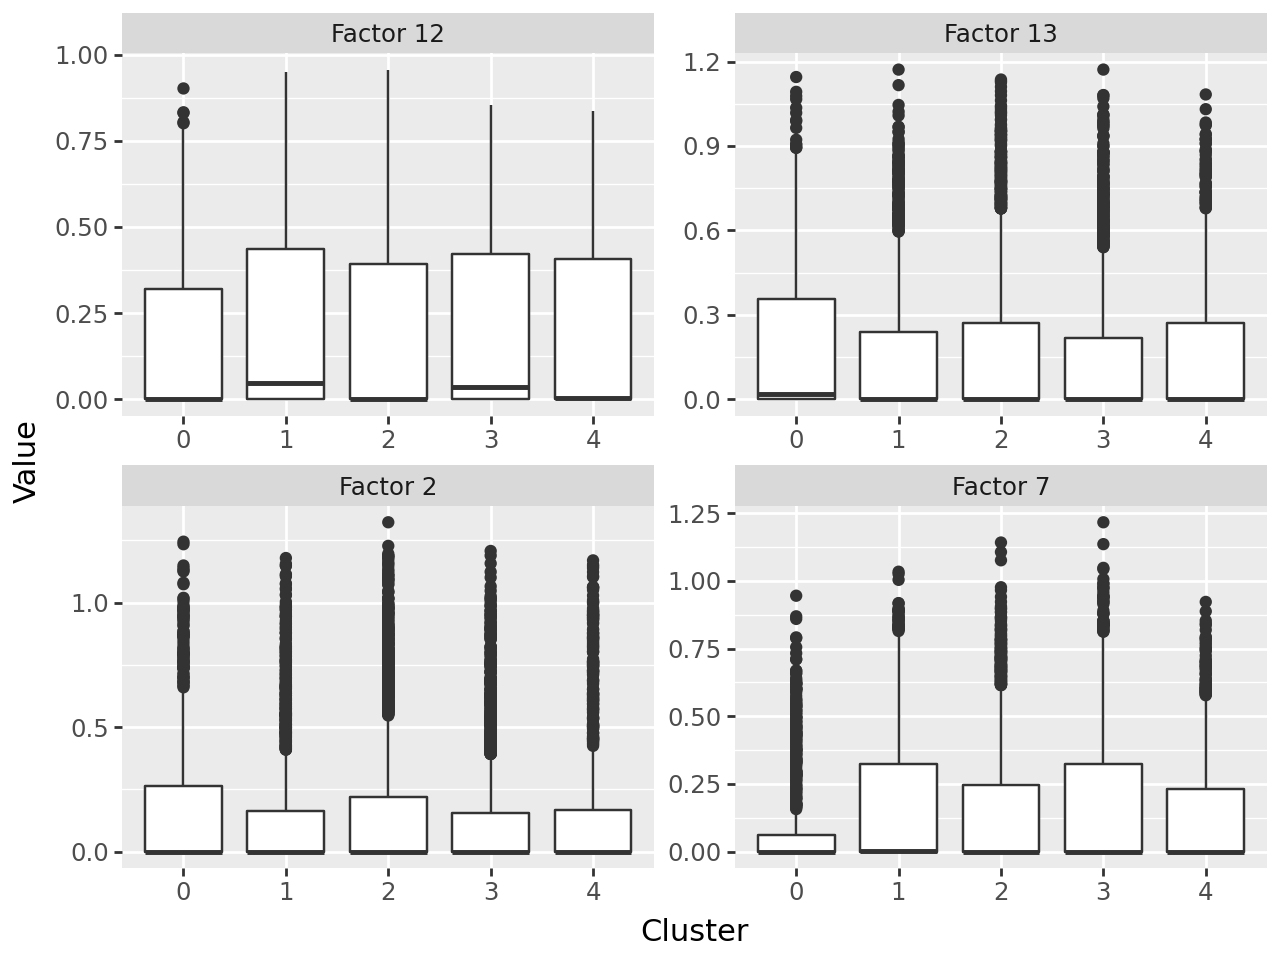

In [13]:
df = factors_celltype[factors].copy()
df["Cluster"] = adata_celltype.obs["cluster"].values
df = df.melt(id_vars=["Cluster"], var_name="Factor", value_name="Value")

plot = (
    ggplot(df, aes(x="Cluster", y="Value"))
    + geom_boxplot()
    + facet_wrap("~Factor", scales="free", ncol=2)
)
plot.show()